# Introducere în Spark Streaming

_____
### Resurse

* [Documentatia oficiala Spark Streaming](http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide)

* [Ghid pentru Spark Streaming cu Kafka](https://www.rittmanmead.com/blog/2017/01/getting-started-with-spark-streaming-with-python-and-kafka/)

* [Un exemplu Spark Streaming cu Geo Plotting](http://nbviewer.jupyter.org/github/ibm-cds-labs/spark.samples/blob/master/notebook/DashDB%20Twitter%20Car%202015%20Python%20Notebook.ipynb)
____

Spark Streaming este o extensie a API-ului nucleului Spark ce permite procesarea stream-urilor live de date. Datele pot fi ingerate din mai multe tipuri de surse precum Kafka, Flume, Kinesis sau socket-uri TCP, și pot fi procesate folosind algoritmi complecși în care intervin funcții de nivel înalt precum map, reduce, join etc. La final, datele procesate pot fi trimise în fișiere ale sistemului de operare, baze de date, dashboard-uri live. Mai mult, asupra stream-urilor de date se pot aplica algoritmii din componentele Spark pentru machine learning și procesarea grafurilor.

<img src='http://spark.apache.org/docs/latest/img/streaming-arch.png'/>

Intern, Spark Streaming primește stream-uri de date de intrare și le divide în batch-uri, care sunt apoi procesate de către motorul Spark pentru a genera stream-ul final de rezultate sub forma de batch-uri.

<img src='http://spark.apache.org/docs/latest/img/streaming-flow.png'/>

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 43.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=dc32125b6b03a285ef9b0cc285e613c9c83542bbdbccbfa82970a37b9070295c
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## Exemplu local

Realizăm numărarea cuvintelor introduse la consolă pe calculatorul local. Preferabil, exemplul trebuie rulat în Unix.

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

# Se creează un obiect StreamingContext local, ci 2 thread-uri și batch interval de 1 secundă
sc = SparkContext("local[2]", "NetworkWordCount")
ssc = StreamingContext(sc, 1)

In [3]:
# Se creează un obiect DStream ce se va conecta la localhost:9999
# Firewall-urile pot bloca această conexiune!
lines = ssc.socketTextStream("localhost", 9999)

In [72]:
# Se divide fiecare linie în cuvinte
words = lines.flatMap(lambda line: line.split(" "))

In [73]:
# Se numără cuvintele din fiecare batch
pairs = words.map(lambda word: (word, 1))
wordCounts = pairs.reduceByKey(lambda x,y: x+y)

# Se afișează primele 10 elemente ale fiecărui RDD generat în DStream la consolă
wordCounts.pprint()

In [10]:
!apt-get -q -y install netcat-openbsd
#!netcat -lk 9999

Reading package lists...
Building dependency tree...
Reading state information...
netcat-openbsd is already the newest version (1.187-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [66]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [64]:
!nc -lk 9999

hello
^C


Se deschide un terminal Unix si lansăm comanda:
$ nc -lk 9999
<br>
După care scriem câteva linii de text, de exemplu:
<br>
hello world any text you want
<br>     
Cu această comandă rulând, executăm celula următoare. După adăugarea câtorva linii de text, încheiem execuția comenzii din terminal (cu Ctrl+C).

In [7]:
!pip install google-colab-shell

  Created wheel for google-colab-shell: filename=google_colab_shell-0.2-py3-none-any.whl size=4124 sha256=5d3f9d53122cccceed774c8690d96078dcc5ebbd80140b1ac726aae0f3db6739
  Stored in directory: /root/.cache/pip/wheels/ee/62/db/d033316a546102d1da60b51a0cc4ddcf0b8c3cc6044469a47b
Successfully built google-colab-shell


In [ ]:
from google_colab_shell import getshell
## Anytime you want to open a terminal

getshell()

#getshell(height=400) # custom height of the terminal

In [ ]:
ssc.start()             # Începe calculul
ssc.awaitTermination()  # Așteaptă să se termine calculul

In [69]:
ssc.stop()
sc.stop()

# Exemplu Twitter
Pentru a putea executa acest exemplu este necesară solicitarea unui cont Twitter Developer API și crearea unei aplicații. Odată aprobat, se vor putea obține credențialele. Dacă sunteți familiari cu procedeul, recuperați direct credențialele necesare de la adresa:

    https://apps.twitter.com/
    
După aceasta, este necesar să instalați python-twitter, o librărie python ce permite conectarea la contul Twitter dev.

Pentru început, completați credențialele și rulați fișierul TweetRead.py. 

In [ ]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [ ]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [ ]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [ ]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [ ]:
lines = socket_stream.window( 20 )

In [ ]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [ ]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

__________
### Now run TweetRead.py
__________

In [ ]:
ssc.start()    

In [ ]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

In [ ]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    sns.plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    sns.plt.show()
    count = count + 1

In [ ]:
ssc.stop()

In [ ]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    sns.plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    sns.plt.show()
    count = count + 1

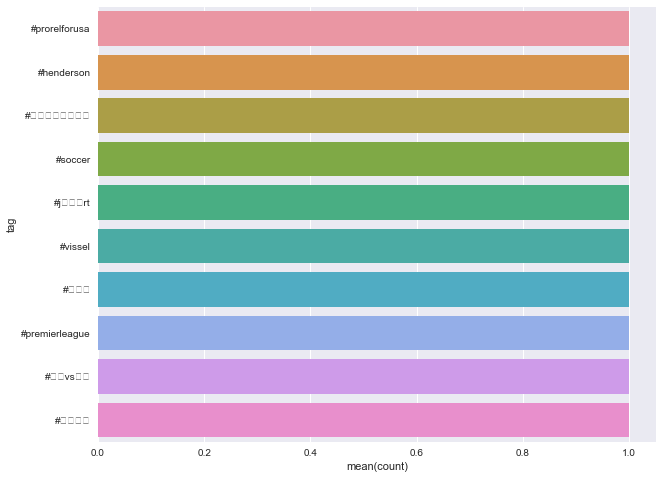

In [ ]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    sns.plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    sns.plt.show()
    count = count + 1